<a href="https://colab.research.google.com/github/MajiroZ/for_git_study/blob/master/CNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [495]:
import numpy as np
import math
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [496]:
# 各種活性化関数の定義
class Sigmoid:
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    def backward(self, dZ):
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig)*_sig
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class Softmax:
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z
    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z - Y
    def loss_func(self, Y, Z=None):
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))

class ReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

# 通常層クラスの定義
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    def forward(self, X):
        # デバッグ用出力
        print(f"Input shape (X): {X.shape}")  # 入力データの形状
        print(f"Weights shape (W): {self.W.shape}")  # 重みの形状
        print(f"Bias shape (B): {self.B.shape}")  # バイアスの形状

        self.X = X
        A = X @ self.W + self.B
        return A

    def backward(self, dA):
        dZ = dA@self.W.T
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        self.optimizer.update(self)
        return dZ

# 重み初期化クラスの定義
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(1 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

class HeInitializer():
    def W(self, n_out_channels, n_in_channels, b_size=1):
        self.sigma = math.sqrt(2 / (n_in_channels*b_size))
        W = self.sigma * np.random.randn(n_out_channels, n_in_channels, b_size)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, *shape):
        W = self.sigma * np.random.randn(*shape)
        return W
    def B(self, *shape):
        B = self.sigma * np.random.randn(*shape)
        return B

# 勾配更新クラスの定義
class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return

class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB

# ミニバッチ生成イテレータの定義
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

各活性化関数にforward関数（順伝播）とbackward関数（逆伝播）の同名の関数を持たせることで、下記のようなイメージで簡単に使用できます。＊イメージのため、下記プログラムは動きません。


```
layers = [ReLU(),ReLU(),Tanh(),Softmax()]
for layer in layers:
    layer.forward()
for layer in layers:
    layer.backward()
```



##【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

In [497]:
class SimpleConv1d():
    def forward(self, x, w, b):
        a = []
        for i in range(len(w) - 1):
            a.append((x[i:i+len(w)] @ w) + b[0])
        return np.array(a)
    def backward(self, x, w, da):
        db = np.sum(da)
        dw = []
        for i in range(len(w)):
            dw.append(da @ x[i:i+len(da)])
        dw = np.array(dw)
        dx = []
        new_w = np.insert(w[::-1], 0, 0)
        new_w = np.append(new_w, 0)
        for i in range(len(new_w)-1):
            dx.append(new_w[i:i+len(da)] @ da)
        dx = np.array(dx[::-1])
        return db, dw, dx

##【問題2】1次元畳み込み後の出力サイズの計算
def output_size_calculation(n_in, F, P=0, S=1):

    n_out = int((n_in + 2 * P - F) / S + 1)
    return n_out

##【問題3】小さな配列での1次元畳み込み層の実験

In [498]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

In [499]:
simple_conv_1d = SimpleConv1d()
simple_conv_1d.forward(x, w, b)

array([35, 50])

In [500]:
a = np.array([35, 50])
a_actual = np.array([45, 70])
da = np.array([10, 20])
db, dw, dx = simple_conv_1d.backward(x, w, da)

In [501]:
db

30

In [502]:
dw

array([ 50,  80, 110])

In [503]:
dx

array([ 30, 110, 170, 140])

In [504]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])

a = np.empty((2, 3))

indexes0 = np.array([0, 1, 2]).astype(int)
indexes1 = np.array([1, 2, 3]).astype(int)

a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である

a = a.sum(axis=1)

In [505]:
x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(int)

print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])

[[1 2 3]
 [2 3 4]]


##【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

In [506]:
# チャンネル数を１に限定しない1次元畳み込み層クラスConv1dを作成する

class Conv1d:
    def __init__(self, b_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, stride=1):
        self.optimizer = optimizer
        self.pa = pa
        self.stride = stride
        self.b_size = b_size
        self.W = initializer.W(n_out_channels, n_in_channels, b_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels

    def forward(self, X):
        self.n_samples = X.shape[0]
        self.n_in = X.shape[2]
        self.n_out = output_size_calculation(self.n_in, self.b_size, self.pa, self.stride)
        X = self._padding(X)
        self.X = X
        A = np.zeros((self.n_samples, self.n_out_channels, self.n_out))
        for i in range(self.n_samples):
            for j in range(self.n_out_channels):
                for k in range(self.n_out):
                    s = k * self.stride
                    A[i, j, k] = np.sum(X[i, :, s:s + self.b_size] * self.W[j]) + self.B[j]
        return A

    def backward(self, dA):
        self.dW = np.zeros_like(self.W)
        self.dB = np.zeros_like(self.B)
        dX = np.zeros_like(self.X)
        for i in range(self.n_samples):
            for j in range(self.n_out_channels):
                for k in range(self.n_out):
                    s = k * self.stride
                    self.dW[j] += dA[i, j, k] * self.X[i, :, s:s + self.b_size]
                    self.dB[j] += dA[i, j, k]
                    dX[i, :, s:s + self.b_size] += dA[i, j, k] * self.W[j]
        self.optimizer.update(self)
        dX = dX[:, :, self.pa:self.n_in + self.pa]
        return dX

    def _padding(self, X):
        if self.pa == 0:
            return X
        return np.pad(X, ((0, 0), (0, 0), (self.pa, self.pa)), 'constant')

In [507]:
import numpy as np

x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])
w = np.ones((3, 2, 3))
b = np.array([1, 2, 3])

conv1d = Conv1d(b_size=3, initializer=SimpleInitializer(0.01), optimizer=None, n_in_channels=2, n_out_channels=3, pa=0, stride=1)

x = x.reshape(1,2,4)

output = conv1d.forward(x)

output

array([[[-0.02819355, -0.03875252],
        [-0.05776577, -0.09398045],
        [ 0.04054174,  0.06230673]]])

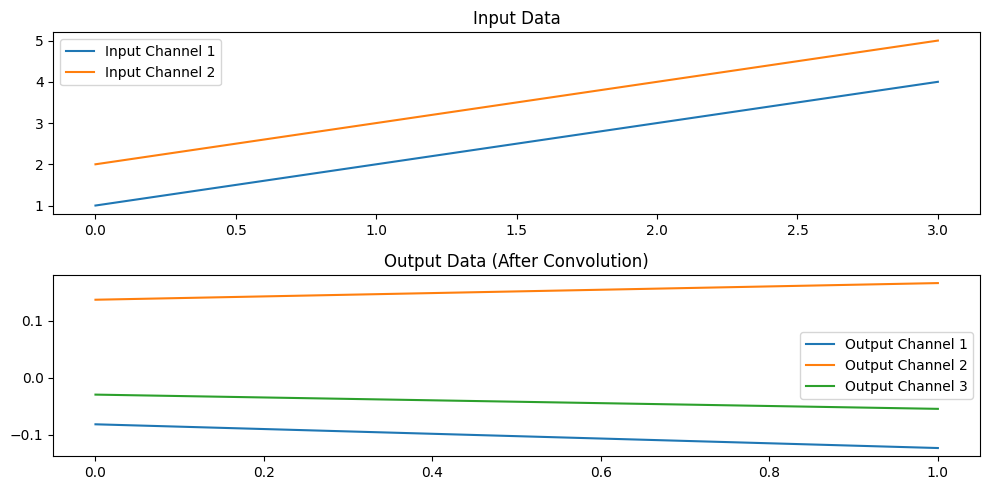

In [508]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])
x = x.reshape(1, 2, 4)
w = np.ones((3, 2, 3))
b = np.array([1, 2, 3])


conv1d = Conv1d(b_size=3, initializer=SimpleInitializer(0.01), optimizer=None, n_in_channels=2, n_out_channels=3, pa=0, stride=1)
output = conv1d.forward(x)


# グラフ
plt.figure(figsize=(10, 5))

# Plot input data
plt.subplot(2, 1, 1)
plt.plot(x[0, 0, :], label='Input Channel 1')
plt.plot(x[0, 1, :], label='Input Channel 2')
plt.title('Input Data')
plt.legend()

# Plot output data
plt.subplot(2, 1, 2)
for i in range(output.shape[1]):
    plt.plot(output[0, i, :], label=f'Output Channel {i+1}')
plt.title('Output Data (After Convolution)')
plt.legend()

plt.tight_layout()
plt.show()

##【問題5】パディングの実装

In [509]:
# ゼロパディングの機能を加える

class Conv1d:
    def __init__(self, b_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, stride=1):
        self.optimizer = optimizer
        self.pa = pa
        self.stride = stride
        self.b_size = b_size
        self.W = initializer.W(n_out_channels, n_in_channels, b_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels

    def forward(self, X):
        self.n_samples = X.shape[0]
        self.n_in = X.shape[2]
        self.n_out = output_size_calculation(self.n_in, self.b_size, self.pa, self.stride)
        X = self._padding(X)
        self.X = X
        A = np.zeros((self.n_samples, self.n_out_channels, self.n_out))
        for i in range(self.n_samples):
            for j in range(self.n_out_channels):
                for k in range(self.n_out):
                    s = k * self.stride
                    A[i, j, k] = np.sum(X[i, :, s:s + self.b_size] * self.W[j]) + self.B[j]
        return A

    def backward(self, dA):
        self.dW = np.zeros_like(self.W)
        self.dB = np.zeros_like(self.B)
        dX = np.zeros_like(self.X)
        for i in range(self.n_samples):
            for j in range(self.n_out_channels):
                for k in range(self.n_out):
                    s = k * self.stride
                    self.dW[j] += dA[i, j, k] * self.X[i, :, s:s + self.b_size]
                    self.dB[j] += dA[i, j, k]
                    dX[i, :, s:s + self.b_size] += dA[i, j, k] * self.W[j]
        self.optimizer.update(self)
        dX = dX[:, :, self.pa:self.n_in + self.pa]
        return dX

    def _padding(self, X):
        if self.pa == 0:
            return X
        # paddingの処理を追加
        pad_width = ((0, 0), (0, 0), (self.pa, self.pa))  # 前後パディング
        return np.pad(X, pad_width, 'constant')


x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])
w = np.ones((3, 2, 3))
b = np.array([1, 2, 3])

conv1d = Conv1d(b_size=3, initializer=SimpleInitializer(0.01), optimizer=None, n_in_channels=2, n_out_channels=3, pa=0, stride=1)

x = x.reshape(1,2,4)

output = conv1d.forward(x)

output

array([[[ 0.02538794,  0.02939636],
        [-0.05932666, -0.08756612],
        [-0.02454851, -0.03742739]]])

##【問題6】ミニバッチへの対応

In [510]:
class Conv1d:
    def __init__(self, b_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, stride=1):
        self.optimizer = optimizer
        self.pa = pa
        self.stride = stride
        self.b_size = b_size
        self.W = initializer.W(n_out_channels, n_in_channels, b_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels

    def forward(self, X):
        self.n_samples = X.shape[0]
        self.n_in = X.shape[2]
        self.n_out = output_size_calculation(self.n_in, self.b_size, self.pa, self.stride)
        print(f"Input shape: {X.shape}, Filter size: {self.b_size}, Output size: {self.n_out}")

        X = self._padding(X)  # パディング適用
        print(f"Padded input shape: {X.shape}")

        self.X = X
        A = np.zeros((self.n_samples, self.n_out_channels, self.n_out))
        for i in range(self.n_samples):
            for j in range(self.n_out_channels):
                for k in range(self.n_out):
                    s = k * self.stride
                    A[i, j, k] = np.sum(X[i, :, s:s + self.b_size] * self.W[j]) + self.B[j]
        print(f"Conv1d output shape (A): {A.shape}")
        return A

    def backward(self, dA):
        self.dW = np.zeros_like(self.W)
        self.dB = np.zeros_like(self.B)
        dX = np.zeros_like(self.X)
        for i in range(self.n_samples):  # バッチごとに計算
            for j in range(self.n_out_channels):
                for k in range(self.n_out):
                    s = k * self.stride
                    self.dW[j] += dA[i, j, k] * self.X[i, :, s:s + self.b_size]
                    self.dB[j] += dA[i, j, k]
                    dX[i, :, s:s + self.b_size] += dA[i, j, k] * self.W[j]
        self.optimizer.update(self)
        dX = dX[:, :, self.pa:self.n_in + self.pa]
        return dX

    def _padding(self, X):
        if self.pa == 0:
            return X
        return np.pad(X, ((0, 0), (0, 0), (self.pa, self.pa)), 'constant')



##【問題7】任意のストライド数

In [511]:
# 任意のストライド数に対応できるようにする

class Conv1d:
    def __init__(self, b_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, stride=1):
        self.optimizer = optimizer
        self.pa = pa
        self.stride = stride
        self.b_size = b_size
        self.W = initializer.W(n_out_channels, n_in_channels, b_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels

    def forward(self, X):
        # Xの形状をデバッグ出力
        print(f"Input X shape: {X.shape}")

        self.n_samples = X.shape[0]
        self.n_in = X.shape[2]
        self.n_out = output_size_calculation(self.n_in, self.b_size, self.pa, self.stride)

        # パディング後のデータ
        X = self._padding(X)
        self.X = X
        print(f"Padded X shape: {self.X.shape}")  # パディング後の形状

        # Aの計算
        A = np.zeros((self.n_samples, self.n_out_channels, self.n_out))
        for i in range(self.n_samples):
            for j in range(self.n_out_channels):
                for k in range(self.n_out):
                    s = k * self.stride
                    A[i, j, k] = np.sum(X[i, :, s:s + self.b_size] * self.W[j]) + self.B[j]

        # Conv1d層の出力をデバッグ出力
        print(f"Conv1d output (A) shape: {A.shape}")
        return A

    def backward(self, dA):
        self.dW = np.zeros_like(self.W)
        self.dB = np.zeros_like(self.B)
        dX = np.zeros_like(self.X)
        for i in range(self.n_samples):
            for j in range(self.n_out_channels):
                for k in range(self.n_out):
                    s = k * self.stride
                    self.dW[j] += dA[i, j, k] * self.X[i, :, s:s + self.b_size]
                    self.dB[j] += dA[i, j, k]
                    dX[i, :, s:s + self.b_size] += dA[i, j, k] * self.W[j]
        self.optimizer.update(self)
        dX = dX[:, :, self.pa:self.n_in + self.pa]
        return dX

    def _padding(self, X):
        if self.pa == 0:
            return X
        return np.pad(X, ((0, 0), (0, 0), (self.pa, self.pa)), 'constant')


x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])
w = np.ones((3, 2, 3))
b = np.array([1, 2, 3])

conv1d = Conv1d(b_size=3, initializer=SimpleInitializer(0.01), optimizer=None, n_in_channels=2, n_out_channels=3, pa=0, stride=1)

x = x.reshape(1,2,4)

output = conv1d.forward(x)

output

Input X shape: (1, 2, 4)
Padded X shape: (1, 2, 4)
Conv1d output (A) shape: (1, 3, 2)


array([[[0.00351186, 0.00103299],
        [0.03868044, 0.05374909],
        [0.02376432, 0.02423279]]])

##【問題8】学習と推定

別バージョン

In [512]:
class ScratchCNNClassifier:
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, verbose=True, Activater=Tanh, Optimizer=AdaGrad):
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.Activater = Activater
        if Activater == Sigmoid or Activater == Tanh:
            self.Initializer = XavierInitializer
        elif Activater == ReLU:
            self.Initializer = HeInitializer
        self.Optimizer = Optimizer

    def predict(self, X):
        X = X.reshape(X.shape[0], 1, X.shape[1])
        return np.argmax(self.forward_propagation(X), axis=1)

    def forward_propagation(self, X):
        A1 = self.Conv1d.forward(X)
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3

    def back_propagation(self,y_true):
        dA3 = self.activation3.backward(y_true)
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = dA1[:, np.newaxis]
        dZ0 = self.Conv1d.backward(dA1)

    def fit(self, X, y, X_val=None, y_val=None):
        self.Conv1d = Conv1d(b_size=7, initializer=SimpleInitializer(0.01), optimizer=self.Optimizer(self.lr), n_in_channels=1, n_out_channels=1, pa=1, stride=1)
        self.Conv1d.n_out = output_size_calculation(X.shape[-1], self.Conv1d.b_size, self.Conv1d.pa, self.Conv1d.stride)
        self.activation1 = self.Activater()
        self.FC2 = FC(1*self.Conv1d.n_out, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = Softmax()
        self.loss = []
        self.loss_epoch = [self.activation3.loss_func(y, self.forward_propagation(X))]
        for _ in range(self.num_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_y)
                self.loss.append(self.activation3.loss)
            self.loss_epoch.append(self.activation3.loss_func(y, self.forward_propagation(X)))

In [515]:
cnn = ScratchCNNClassifier(num_epoch=1, lr=0.01, batch_size=1, n_features=784, n_nodes1=400, n_nodes2=400, n_output=10, verbose=True, Activater=Sigmoid, Optimizer=SGD)
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
cnn.fit(X_train_reshaped, y_train)

ストリーミング出力は最後の 5000 行に切り捨てられました。
Weights shape (W): (780, 400)
Bias shape (B): (400,)
Input shape (X): (1, 400)
Weights shape (W): (400, 10)
Bias shape (B): (10,)
Input X shape: (1, 1, 784)
Padded X shape: (1, 1, 786)
Conv1d output (A) shape: (1, 1, 780)
Input shape (X): (1, 780)
Weights shape (W): (780, 400)
Bias shape (B): (400,)
Input shape (X): (1, 400)
Weights shape (W): (400, 10)
Bias shape (B): (10,)
Input X shape: (1, 1, 784)
Padded X shape: (1, 1, 786)
Conv1d output (A) shape: (1, 1, 780)
Input shape (X): (1, 780)
Weights shape (W): (780, 400)
Bias shape (B): (400,)
Input shape (X): (1, 400)
Weights shape (W): (400, 10)
Bias shape (B): (10,)
Input X shape: (1, 1, 784)
Padded X shape: (1, 1, 786)
Conv1d output (A) shape: (1, 1, 780)
Input shape (X): (1, 780)
Weights shape (W): (780, 400)
Bias shape (B): (400,)
Input shape (X): (1, 400)
Weights shape (W): (400, 10)
Bias shape (B): (10,)
Input X shape: (1, 1, 784)
Padded X shape: (1, 1, 786)
Conv1d output (A) shape: (1, 1, 780)
In

In [516]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

Input X shape: (10000, 1, 784)
Padded X shape: (10000, 1, 786)
Conv1d output (A) shape: (10000, 1, 780)
Input shape (X): (10000, 780)
Weights shape (W): (780, 400)
Bias shape (B): (400,)
Input shape (X): (10000, 400)
Weights shape (W): (400, 10)
Bias shape (B): (10,)


0.9125